In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import glob
import os

from scipy import signal
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


          time  ch1  ch2  ch3  button
0          1.0  3.3  3.3  3.3       0
1          3.0  3.3  3.3  3.3       0
2          5.0  3.3  3.3  3.3       0
3          7.0  3.3  3.3  3.3       0
4          9.0  3.3  3.3  3.3       0
...        ...  ...  ...  ...     ...
24973  49968.0  3.3  3.3  3.3       0
24974  49970.0  3.3  3.3  3.3       0
24975  49972.0  0.0  3.3  0.0       0
24976  49974.0  0.0  3.3  0.0       0
24977  49976.0  0.0  3.3  0.0       0

[24978 rows x 5 columns]


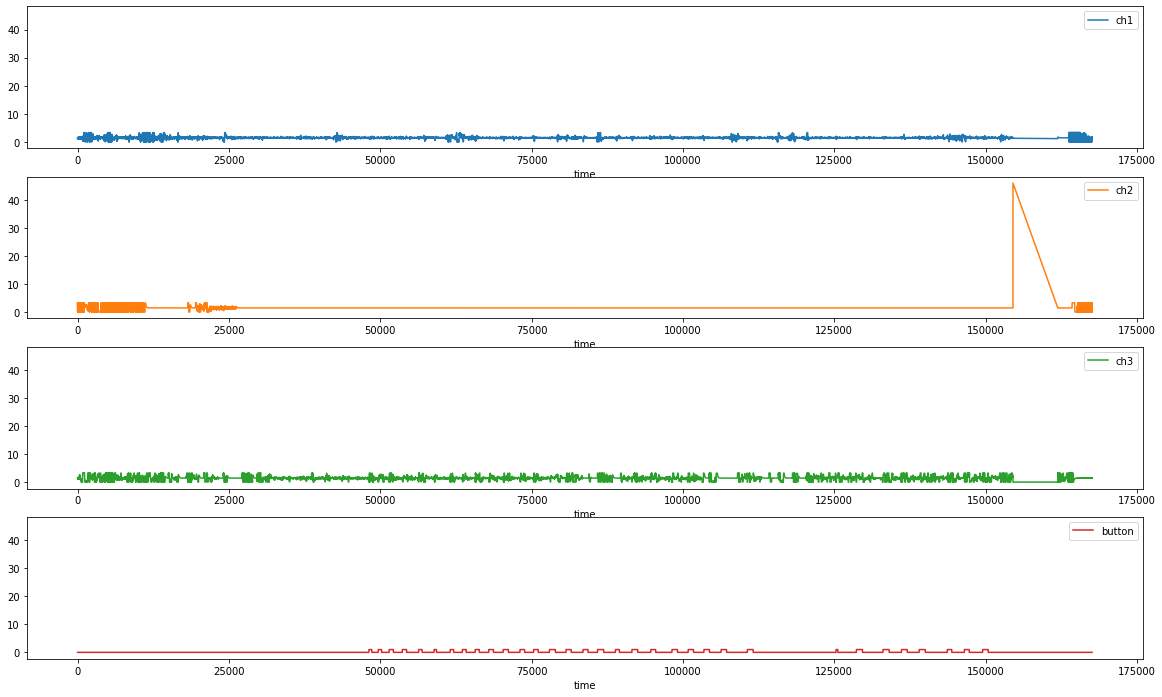

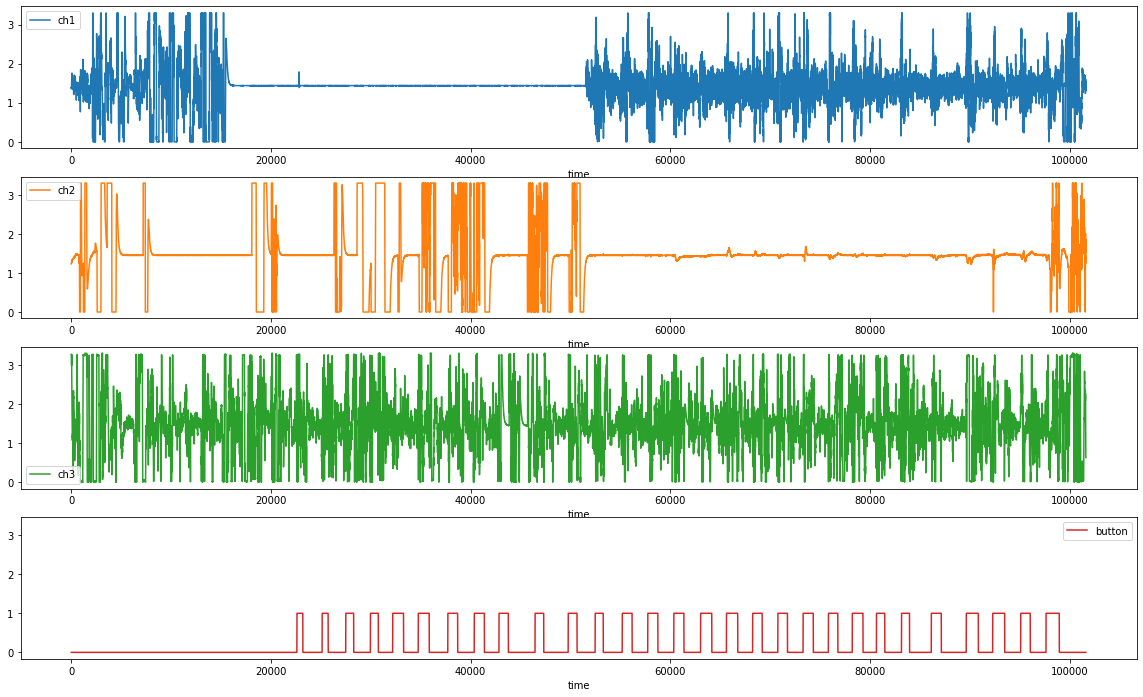

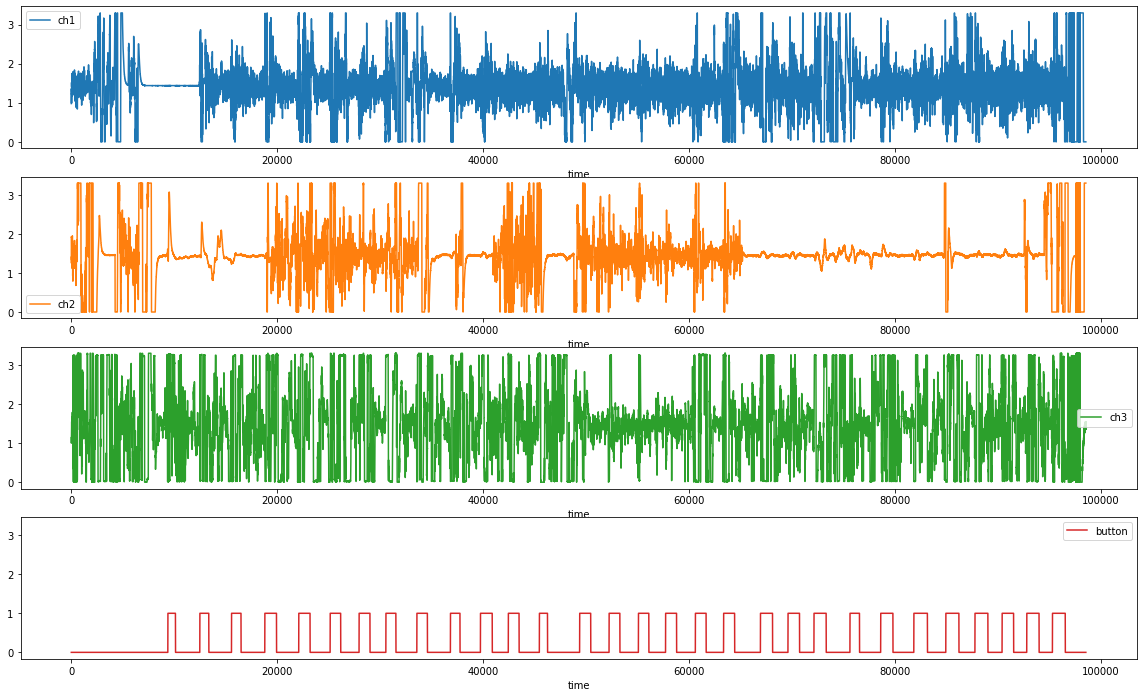

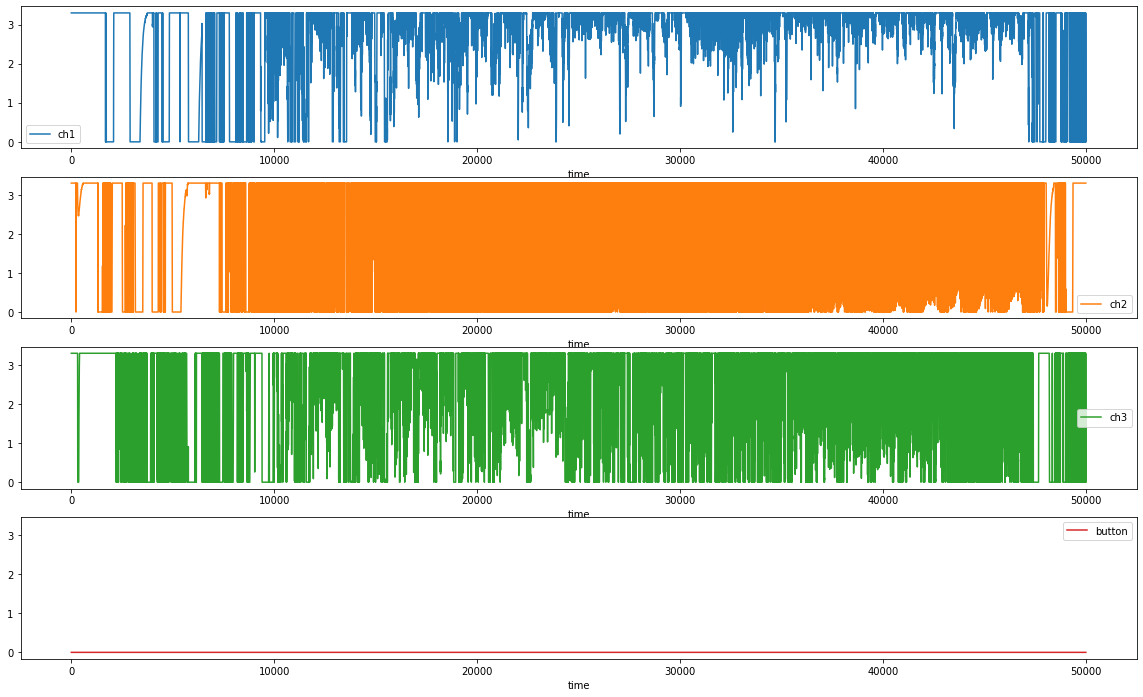

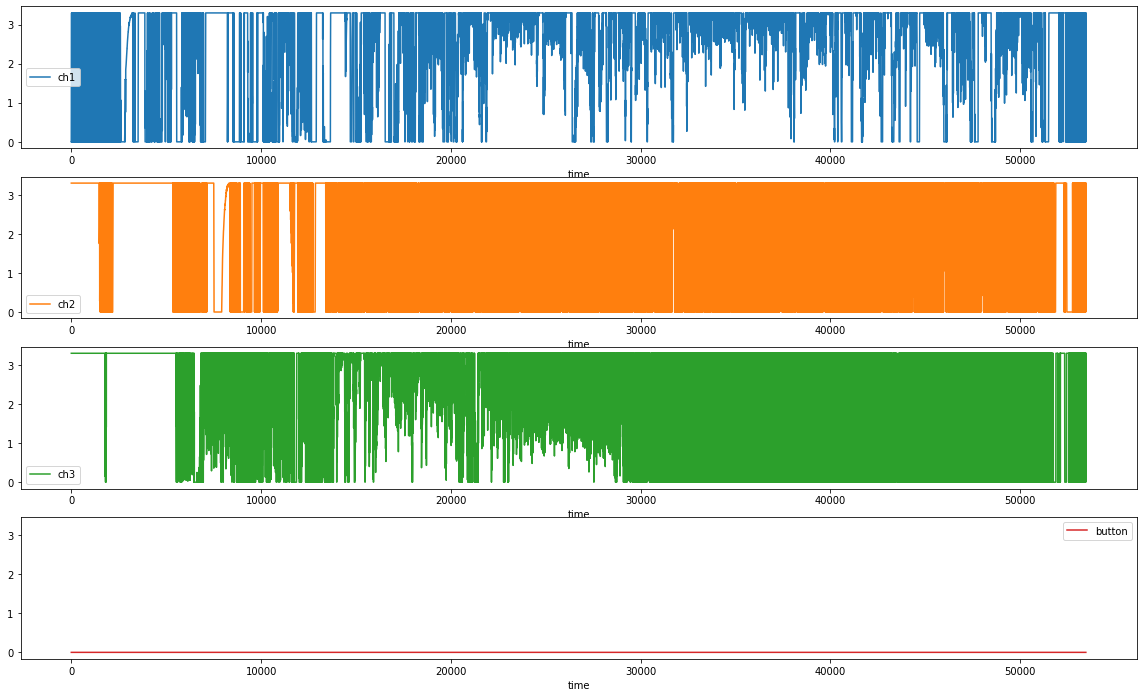

In [36]:
words = ['no', 'yes', 'start', 'ok', 'stop']

df_list = {}

for i, word in enumerate(words):
    df_list[word] = pd.read_csv(f'dataset/20220124/{word}.csv')
    df_list[word].plot(x='time', subplots=True, sharex=False, sharey=True, figsize=(20, 12))

print(df_list['ok'])

In [37]:
import librosa

In [117]:
# mfcc
# 参考:
# * https://aidiary.hatenablog.com/entry/20120225/1330179868
# * https://work-in-progress.hatenablog.com/entry/2020/02/24/103750

mfccs = librosa.feature.mfcc(df_list['ok']['ch1'][3000:4000].values, sr=1000, n_mfcc=20, n_mels=128,
                            win_length=50,
                            hop_length=25,
                            n_fft=512,
                            dct_type=2)

In [118]:
print(mfccs.shape)
print(mfccs[1])

(20, 41)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.21293137e+02 1.38060404e+02 1.21957324e+02
 9.16438057e+01 6.52675307e+01 0.00000000e+00 0.00000000e+00
 1.11469925e-16 2.41944969e+01 2.80620325e+01 4.24227642e+01
 4.65242426e+01 4.98582325e+01 7.92789452e+01 4.20775367e+01
 3.89360945e+01 6.99801808e+01 3.09899955e+01 8.71559117e+01
 1.07336924e+02 1.77616873e+02 2.36529412e+01 4.89578092e+01
 6.90656649e+01 7.39818548e+01 4.08879645e+01 8.49108948e+01
 1.77616873e+02 1.77616873e+02 1.77616873e+02 1.40451349e+02
 1.35422838e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


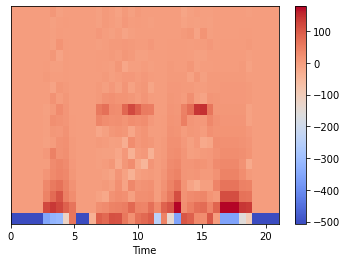

In [119]:
import librosa.display

librosa.display.specshow(mfccs, sr=1000, x_axis='time')
plt.colorbar()

In [163]:
# yes no start.....をMFCC特徴量で分類
# training 10, validation 2, test 2

# no
# df[5000:6000].plot(x='time', subplots=True, sharex=False, sharey=True, figsize=(20, 12))

n = 5000

train_data = []

# mfccを計算して、各チャンネル6個までを使う
# no

mfccs = {}
mfccs_list = []

n = 0

#
# 各単語ごとに20個のデータを用意する。5000msecから1000ずつずらして取り込む
#
for word in words:
    print(word)
    n = 5000
    for i in range(20):
        mfccs[f'{word}_1'] = librosa.feature.mfcc(df_list[word]['ch1'][n:n+1000].values, sr=1000, n_mfcc=20, n_mels=128,
                                                  win_length=50,
                                                  hop_length=25,
                                                  n_fft=512,
                                                  dct_type=2)
        mfccs[f'{word}_2'] = librosa.feature.mfcc(df_list[word]['ch2'][n:n+1000].values, sr=1000, n_mfcc=20, n_mels=128,
                            win_length=50,
                            hop_length=25,
                            n_fft=512,
                            dct_type=2)
        mfccs[f'{word}_3'] = librosa.feature.mfcc(df_list[word]['ch3'][n:n+1000].values, sr=1000, n_mfcc=20, n_mels=128,
                            win_length=50,
                            hop_length=25,
                            n_fft=512,
                            dct_type=2)
        ch1_mfccs = np.concatenate([mfccs[f'{word}_1'][0], mfccs[f'{word}_1'][1], mfccs[f'{word}_1'][2], mfccs[f'{word}_1'][3], mfccs[f'{word}_1'][4], mfccs[f'{word}_1'][5], mfccs[f'{word}_1'][6]], 0)
        ch2_mfccs = np.concatenate([mfccs[f'{word}_2'][0], mfccs[f'{word}_2'][1], mfccs[f'{word}_2'][2], mfccs[f'{word}_2'][3], mfccs[f'{word}_2'][4], mfccs[f'{word}_2'][5], mfccs[f'{word}_2'][6]], 0)
        ch3_mfccs = np.concatenate([mfccs[f'{word}_3'][0], mfccs[f'{word}_3'][1], mfccs[f'{word}_3'][2], mfccs[f'{word}_3'][3], mfccs[f'{word}_3'][4], mfccs[f'{word}_3'][5], mfccs[f'{word}_3'][6]], 0)
        train_data.append(np.concatenate([ch1_mfccs, ch2_mfccs, ch3_mfccs]))
        n = n + 1000
print(len(train_data))

no
yes
start
ok
stop
100


In [164]:
# 正解ラベルを作る
# [1, 0, 0]
# [0, 1, 0]
#
# start,stopの単語を2chで取得
num_array = [0] * 16 + [1] * 16 + [2] * 16 + [3] * 16 + [4] * 16
print(num_array)

#print(np.identity(5)[num_array])

# label_data = np.concatenate([np.zeros(16), np.ones(16), np.full(16, 3)])
label_data = np.identity(5)[num_array]

#y_train = tf.keras.utils.to_categorical(label_data)
#print(y_train)
y_train = label_data

# test_label_data = np.concatenate([np.zeros(4), np.ones(4), np.full(4, 4)])
#y_test = tf.keras.utils.to_categorical(test_label_data)

num_array2 = [0] * 4 + [1] * 4 + [2] * 4 + [3] * 4 + [4] * 4
y_test = label_data = np.identity(5)[num_array2]
print(y_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [165]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras import optimizers

train_X = np.concatenate([train_data[0:16], train_data[20:36], train_data[40:56], train_data[60:76], train_data[80:96]])
print(train_X.shape)

print(len(train_X))
print(type(train_X))

# モデルの作成
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(861, )))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='ADAM',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

(80, 861)
80
<class 'numpy.ndarray'>
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               86200     
                                                                 
 flatten_4 (Flatten)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_19 (Dense)

In [166]:
history = model.fit(train_X, y_train,
                    batch_size=128,   # 64,128みたいに2の倍数がよく使われるらしい
                    epochs=200,
                    verbose=2,
                    validation_split=0.1)

Epoch 1/200
1/1 - 0s - loss: 86.8192 - accuracy: 0.1806 - val_loss: 10.9422 - val_accuracy: 0.2500 - 463ms/epoch - 463ms/step
Epoch 2/200
1/1 - 0s - loss: 40.0221 - accuracy: 0.2361 - val_loss: 18.9545 - val_accuracy: 0.0000e+00 - 24ms/epoch - 24ms/step
Epoch 3/200
1/1 - 0s - loss: 26.8897 - accuracy: 0.3611 - val_loss: 22.9946 - val_accuracy: 0.0000e+00 - 24ms/epoch - 24ms/step
Epoch 4/200
1/1 - 0s - loss: 19.2423 - accuracy: 0.4861 - val_loss: 28.4631 - val_accuracy: 0.0000e+00 - 25ms/epoch - 25ms/step
Epoch 5/200
1/1 - 0s - loss: 21.4906 - accuracy: 0.5000 - val_loss: 31.8411 - val_accuracy: 0.0000e+00 - 24ms/epoch - 24ms/step
Epoch 6/200
1/1 - 0s - loss: 19.4506 - accuracy: 0.4306 - val_loss: 31.7999 - val_accuracy: 0.0000e+00 - 25ms/epoch - 25ms/step
Epoch 7/200
1/1 - 0s - loss: 11.4701 - accuracy: 0.5694 - val_loss: 31.5129 - val_accuracy: 0.0000e+00 - 25ms/epoch - 25ms/step
Epoch 8/200
1/1 - 0s - loss: 12.2861 - accuracy: 0.5417 - val_loss: 31.8180 - val_accuracy: 0.0000e+00 - 2

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

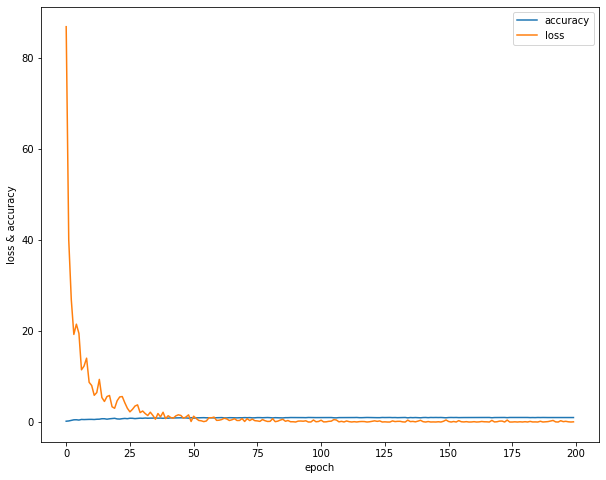

In [167]:
import matplotlib.pyplot as plt

hist_df = pd.DataFrame(history.history)
plt.figure()
hist_df[['accuracy', 'loss']].plot(figsize=(10,8))
plt.ylabel('loss & accuracy')
plt.xlabel('epoch')

In [171]:
print(train_data[56:60])
test_X = np.concatenate([train_data[16:20], train_data[36:40], train_data[56:60], train_data[76:80], train_data[96:100]])
#train_X = np.concatenate([train_data[0:16], train_data[20:36], train_data[40:56], train_data[60:76], train_data[80:96]])

print(train_X.shape)

print("Evaluate on test data")
results = model.evaluate(test_X, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
predictions = model.predict(test_X[0:20])
print("predictions shape:", predictions)


[array([-9.85305629e+01, -9.71760218e+01, -5.65884288e+01, -1.13126238e+02,
       -5.98685827e+01, -6.91201568e+01, -3.21203428e+01, -2.84638012e+01,
       -8.33247834e+01, -5.40403438e+01, -5.62690146e+01, -4.47836462e+01,
       -3.75114586e+01, -6.53831798e+01, -6.65987604e+01, -4.56022376e+01,
       -5.37600239e+01, -3.72102583e+01, -7.88784373e+01, -4.56950274e+01,
       -4.43357548e+01, -6.60314150e+01, -4.24566521e+01, -5.65656539e+01,
       -5.34794526e+01, -1.73152438e+01, -9.68276240e+01, -7.71915275e+01,
       -1.15722420e+02, -9.90121632e+01, -9.68248747e+01, -6.31287322e+01,
       -4.47321556e+01, -4.62334931e+01, -8.95804954e+01, -6.83274574e+01,
       -8.32160607e+01, -4.36954312e+01, -6.70978294e+01, -7.95073171e+01,
       -8.08006890e+01,  6.79913091e+01,  7.64012239e+01,  8.31896966e+01,
        8.03445689e+01,  6.67689746e+01,  7.59198080e+01,  6.39362247e+01,
        8.11034912e+01,  9.83360909e+01,  4.89691136e+01,  6.45280908e+01,
        6.59164022e+01, 

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 3 has 1 dimension(s)